In [1]:
# The SageMaker Studio environment comes with most of these pre-installed.
# This cell ensures all dependencies are present.
!pip install -q boto3 sagemaker mlflow "scikit-learn>=1.0" "pandas>=1.2" 

In [1]:
pip show sagemaker_mlflow

Name: sagemaker-mlflow
Version: 0.1.0
Summary: AWS Plugin for MLFlow with SageMaker
Home-page: https://github.com/aws/sagemaker-mlflow
Author: Amazon Web Services
Author-email: 
License: Apache License 2.0
Location: /opt/conda/lib/python3.12/site-packages
Requires: boto3, mlflow
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [1]:
import sys
import subprocess

# Ensure MLflow is installed
try:
    import mlflow
    import sagemaker_mlflow
except ImportError:
    print("Installing MLflow...")
    subprocess.check_call([sys.executable, "-m", "pip", "install",  "boto3==1.37.1", "botocore==1.37.1", "s3transfer", "mlflow==2.22.0", "sagemaker-mlflow==0.1.0", "matplotlib"])
    import mlflow
    import sagemaker_mlflow

In [5]:
import sagemaker
import boto3
import mlflow
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
import os

# Setup SageMaker session
sagemaker_session = sagemaker.Session()
sagemaker_client = boto3.client("sagemaker")

# --- IMPORTANT: CONFIGURE THESE VARIABLES ---
# s3_bucket = sagemaker_session.default_bucket()
# ----------------------
# UPDATE THESE VARIABLES
bucket_name = 'iti113-team2-bucket'
base_folder = 'Team2'
# ----------------------

# Create source folder
folder_path = "source"
os.makedirs(folder_path, exist_ok=True)
print(f"Folder created (or already exists): {folder_path}")

s3_client = boto3.client('s3')

data_path = f"s3://{bucket_name}/{base_folder}"

# Assuming you have your boto3 client and server name
tracking_server_name = "mlflow-ITI113-Team2"

try:
    response = sagemaker_client.describe_mlflow_tracking_server(
        TrackingServerName=tracking_server_name
    )
    tracking_server_arn = response['TrackingServerArn']
    print(f"Found MLflow Tracking Server ARN: {tracking_server_arn}")
except Exception as e:
    print(f"Could not find tracking server: {e}")
    tracking_server_arn = None

# ARN of your MLflow Tracking Server
mlflow_tracking_server_arn = tracking_server_arn

# IAM role for SageMaker execution
role = sagemaker.get_execution_role()

print(f"S3 Bucket: {data_path}")
print(f"SageMaker Role ARN: {role}")
print(f"MLflow Tracking Server ARN: {mlflow_tracking_server_arn}")

Folder created (or already exists): source
Found MLflow Tracking Server ARN: arn:aws:sagemaker:ap-southeast-1:837028399719:mlflow-tracking-server/mlflow-ITI113-Team2
S3 Bucket: s3://iti113-team2-bucket/Team2
SageMaker Role ARN: arn:aws:iam::837028399719:role/iti113-team2-sagemaker-iti113-team2-domain-iti113-team2-Role
MLflow Tracking Server ARN: arn:aws:sagemaker:ap-southeast-1:837028399719:mlflow-tracking-server/mlflow-ITI113-Team2


-----
### Upload dataset to S3

In [6]:
# Upload to S3
s3_client.upload_file('data/Team2Dataset.csv', bucket_name, f'{base_folder}/data/Team2Dataset.csv')
s3_path = f"s3://{bucket_name}/{base_folder}/data/Team2Dataset.csv"
data_s3_uri = os.path.dirname(s3_path) # Log the directory URI

print(data_s3_uri)

s3://iti113-team2-bucket/Team2/data


-----

### Creating the SageMaker Pipeline

Create the pipeline scripts that will be executed as steps in our SageMaker Pipeline.


### Pipeline Definition

Define the SageMaker Pipeline using the scripts we just created.

In [7]:
from sagemaker.workflow.pipeline import Pipeline
from sagemaker.workflow.steps import ProcessingStep, TrainingStep, TrainingInput
from sagemaker.processing import ScriptProcessor, ProcessingInput, ProcessingOutput
from sagemaker.workflow.properties import PropertyFile
from sagemaker.sklearn.estimator import SKLearn
from sagemaker.workflow.step_collections import RegisterModel
from sagemaker.workflow.conditions import ConditionGreaterThanOrEqualTo
from sagemaker.workflow.conditions import ConditionNot
from sagemaker.workflow.condition_step import ConditionStep
from sagemaker.workflow.conditions import ConditionEquals
from sagemaker.workflow.functions import JsonGet
from sagemaker.workflow.functions import Join
from sagemaker.workflow.parameters import ParameterFloat, ParameterString, ParameterInteger
from sagemaker.model_metrics import ModelMetrics, FileSource
import json
import boto3

# Parameters
model_package_group_name = "Team2PredictorModels"
processing_instance_type = "ml.t3.medium"
training_instance_type = "ml.m5.large"

experiment_name_param = ParameterString(name="experiment_name", default_value="Team2-Model-Experiment")
accuracy_threshold_param = ParameterFloat(name="AccuracyThreshold", default_value=0.80)

model_type_param = ParameterString(name="model_type", default_value="logistic_regression")
model_param_grid_param = ParameterString(name="model_param_grid")
model_random_state_param = ParameterInteger(name="random_state")
model_max_iter_param = ParameterInteger(name="max_iter", default_value=100)
model_cv_param = ParameterInteger(name="model_cv")

# model_c_param = ParameterFloat(name="c_param", default_value=0.5)
# model_n_estimators_param = ParameterInteger(name="n_estimators", default_value=100)
# model_max_depth_param = ParameterInteger(name="max_depth", default_value=5)

run_name_param = ParameterString(name="run_name", default_value="run-default")
s3_client = boto3.client('s3')

def get_next_version(bucket_name, prefix):
    
    # Ensure prefix ends with '/'
    if not prefix.endswith('/'):
        prefix += '/'

    # List objects under the prefix
    response = s3_client.list_objects_v2(Bucket=bucket_name, Prefix=prefix, Delimiter='/')
    
    version_numbers = []
    for obj in response.get('CommonPrefixes', []):
        folder_name = obj.get('Prefix').split('/')[-2]  # Get last folder in path before trailing '/'
        if folder_name.startswith('v'):
            try:
                version_numbers.append(int(folder_name[1:]))
            except ValueError:
                continue

    next_version = max(version_numbers, default=0) + 1
    version_folder = f"v{next_version}"
    return version_folder

#find next version folder
s3_process_train_folder = f"{base_folder}/processing/train" #base folder
version_folder = get_next_version(bucket_name, s3_process_train_folder)
print(f"Next version: {version_folder}")

#set new version folder
s3_process_train_path = f"s3://{bucket_name}/{base_folder}/processing/train/{version_folder}"
s3_process_test_path = f"s3://{bucket_name}/{base_folder}/processing/test/{version_folder}"
s3_process_artifact_path = f"s3://{bucket_name}/{base_folder}/processing/artifacts/{version_folder}"
# print(s3_process_train_path)
# print(s3_process_test_path)

preprocessor = ScriptProcessor(
    image_uri=sagemaker.image_uris.retrieve("sklearn", sagemaker_session.boto_region_name, "1.2-1"),
    command=[
        "python3",
    ],
    instance_type=processing_instance_type,
    instance_count=1,
    base_job_name="preprocess-data",
    role=role,
)

step_preprocess = ProcessingStep(
    name="PreprocessData",
    processor=preprocessor,
    inputs=[ProcessingInput(source=data_s3_uri, destination="/opt/ml/processing/input")],
    outputs=[
        ProcessingOutput(output_name="train", source="/opt/ml/processing/train", destination=s3_process_train_path),
        ProcessingOutput(output_name="test", source="/opt/ml/processing/test", destination=s3_process_test_path),
        ProcessingOutput(output_name="transformers", source="/opt/ml/processing/artifacts", destination=s3_process_artifact_path),
    ],
    code="source/preprocess.py",
)

# Training Step
sklearn_estimator = SKLearn(
    entry_point="train.py",
    source_dir="source",
    framework_version="1.2-1",
    instance_type=training_instance_type,
    role=role,
    hyperparameters={
        "tracking_server_arn": mlflow_tracking_server_arn,
        "experiment_name": experiment_name_param,
        "model_type": model_type_param,
        "model_param_grid": model_param_grid_param,
        "random_state": model_random_state_param,
        "max_iter": model_max_iter_param,
        "model_cv": model_cv_param,
        "model_output_path": "/opt/ml/model",
        "run_name": run_name_param,
    },
    py_version="py3",
    requirements="source/requirements.txt"
)

step_train = TrainingStep(
    name="TrainModel",
    estimator=sklearn_estimator,
    inputs={
        "train": TrainingInput(
            s3_data=step_preprocess.properties.ProcessingOutputConfig.Outputs["train"].S3Output.S3Uri,
            content_type="text/csv",
        )
    },
)

# Evaluation Step
evaluation_processor = ScriptProcessor(
    image_uri=sagemaker.image_uris.retrieve("sklearn", sagemaker_session.boto_region_name, "1.2-1"),
    command=['python3'],
    instance_type=processing_instance_type,
    instance_count=1,
    base_job_name="evaluate-model",
    role=role,
)

evaluation_report = PropertyFile(
    name="EvaluationReport", output_name="evaluation", path="evaluation.json"
)

step_eval = ProcessingStep(
    name="EvaluateModel",
    processor=evaluation_processor,
    inputs=[
        ProcessingInput(
            source=step_train.properties.ModelArtifacts.S3ModelArtifacts,
            destination="/opt/ml/processing/model",
        ),
        ProcessingInput(
            source=step_preprocess.properties.ProcessingOutputConfig.Outputs["test"].S3Output.S3Uri,
            destination="/opt/ml/processing/test",
        ),
    ],
    outputs=[ProcessingOutput(output_name="evaluation", source="/opt/ml/processing/evaluation")],
    code="source/evaluate.py",  # SageMaker will handle uploading and running this script
    job_arguments=[  # Pass arguments here instead of in command
        "--model-path", "/opt/ml/processing/model",
        "--test-path", "/opt/ml/processing/test",
        "--output-path", "/opt/ml/processing/evaluation",
        "--model-package-group-name", model_package_group_name,
        "--region", "ap-southeast-1",
    ],
    property_files=[evaluation_report],
)


model_metrics_report = ModelMetrics(
    model_statistics=FileSource(
        s3_uri=step_eval.properties.ProcessingOutputConfig.Outputs["evaluation"].S3Output.S3Uri,
        content_type="application/json"
    )
)


# RegisterModel step (always defined, but executed conditionally)
step_register_new = RegisterModel(
    name="RegisterNewModel",
    estimator=sklearn_estimator,
    model_data=step_train.properties.ModelArtifacts.S3ModelArtifacts,
    content_types=["application/json"],
    response_types=["application/json"],
    inference_instances=["ml.t2.medium"],
    transform_instances=["ml.m5.large"],
    model_package_group_name="Team2PredictorModels",
    model_metrics=model_metrics_report,
    approval_status="PendingManualApproval",
)

step_register_better_model = RegisterModel(
    name="RegisterBetterModel",
    estimator=sklearn_estimator,
    model_data=step_train.properties.ModelArtifacts.S3ModelArtifacts,
    content_types=["application/json"],
    response_types=["application/json"],
    inference_instances=["ml.t2.medium"],
    transform_instances=["ml.m5.large"],
    model_package_group_name="Team2PredictorModels",
    model_metrics=model_metrics_report,
    approval_status="PendingManualApproval",
)


# Conditions: check accuracy > threshold OR no model exists
cond_accuracy = ConditionGreaterThanOrEqualTo(
    left=JsonGet(
        step_name=step_eval.name,
        property_file=evaluation_report,
        json_path="accuracy"
    ),
    right=accuracy_threshold_param
)

cond_no_registered = ConditionEquals(
    left=JsonGet(
        step_name=step_eval.name,
        property_file=evaluation_report,
        json_path="baseline_exists" # Check the key added to the report
    ),
    right=False # Condition is TRUE if baseline_exists is False
)

# Outer step: Check if model is better
step_cond_accuracy = ConditionStep(
    name="CheckAccuracy",
    conditions=[cond_accuracy],
    if_steps=[step_register_better_model], # Register model if accuracy is high
    else_steps=[],
)

# Checks for existence of registered model first
step_cond_no_registered = ConditionStep(
    name="CheckIfModelExists",
    conditions=[cond_no_registered],
    if_steps=[step_register_new],  # Register model if no baseline exists
    else_steps=[step_cond_accuracy],
)


# Define Pipeline
pipeline = Pipeline(
    name="Team2PredictionPipeline",
    parameters=[experiment_name_param, accuracy_threshold_param, model_type_param, model_param_grid_param, model_random_state_param, model_max_iter_param, model_cv_param, run_name_param],
    steps=[step_preprocess, step_train, step_eval, step_cond_no_registered] # Use the 'no registered model' check as the primary condition step
)

# #Test
# pipeline = Pipeline(
#     name="Team2PredictionPipeline",
#     parameters=[experiment_name_param, accuracy_threshold_param, model_type_param, model_param_grid_param, model_random_state_param, model_max_iter_param, model_cv_param, run_name_param],
#     steps=[step_preprocess, step_train] # Use the 'no registered model' check as the primary condition step
# )

pipeline.upsert(role_arn=role)
print("Team2PredictionPipeline is defined and ready to be executed.")

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.
INFO:sagemaker.image_uris:Defaulting to only available Python version: py3


Next version: v2


INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.


Team2PredictionPipeline is defined and ready to be executed.


### Execute Pipeline

----
#### Experiment 1 - Execute logistic_regression

In [5]:
from sagemaker.workflow.pipeline import Pipeline
from sagemaker.session import Session
import boto3
import json

pipeline_name = "Team2PredictionPipeline"

# Load existing pipeline
pipeline = Pipeline(name=pipeline_name, sagemaker_session=None)

model_param_grid = {
    "C": [0.01, 0.1, 1, 10, 100],
    "class_weight": ["balanced"],
    "penalty": ["l1", "l2"],
    "solver": ["liblinear"]
}

# Correct JSON string for param
json_param_grid = json.dumps(model_param_grid)
print(json_param_grid)

execution = pipeline.start(
    parameters={
        "model_type": "logistic_regression",
        "model_param_grid": json_param_grid,
        "random_state": 42,
        "max_iter": 1000,
        "model_cv": 5,
        "run_name": "run-v1"
    }
)

print("Pipeline execution started.")
print(execution.arn)
try:
    execution.wait()
    print("Pipeline execution completed.")
    execution.describe()
except Exception as e:
    print("Pipeline execution failed:", str(e))

{"C": [0.01, 0.1, 1, 10, 100], "class_weight": ["balanced"], "penalty": ["l1", "l2"], "solver": ["liblinear"]}
Pipeline execution started.
arn:aws:sagemaker:ap-southeast-1:837028399719:pipeline/Team2PredictionPipeline/execution/0sy2dgri7l9z
Pipeline execution completed.


----
#### Experiment 2 - Execute random_forest

In [6]:
#random_forest
from sagemaker.workflow.pipeline import Pipeline
import boto3
import json

pipeline_name = "Team2PredictionPipeline"

# Load existing pipeline
pipeline = Pipeline(name=pipeline_name, sagemaker_session=None)

model_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [100, 200, None],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced']
}

# Correct JSON string for param
json_param_grid = json.dumps(model_param_grid)
print(json_param_grid)

execution = pipeline.start(
    parameters={
        "model_type": "random_forest",
        "model_param_grid": json_param_grid,
        "random_state": 42,
        "model_cv": 5,
        "run_name": "run-v2"
    }
)

print("Pipeline execution started.")
print(execution.arn)
try:
    execution.wait()
    print("Pipeline execution completed.")
    execution.describe()
except Exception as e:
    print("Pipeline execution failed:", str(e))

{"n_estimators": [100, 200], "max_depth": [100, 200, null], "min_samples_split": [2, 5], "class_weight": ["balanced"]}
Pipeline execution started.
arn:aws:sagemaker:ap-southeast-1:837028399719:pipeline/Team2PredictionPipeline/execution/zqoarj9wlsf8
Pipeline execution completed.


### Team2PredictionPipeline - Graph
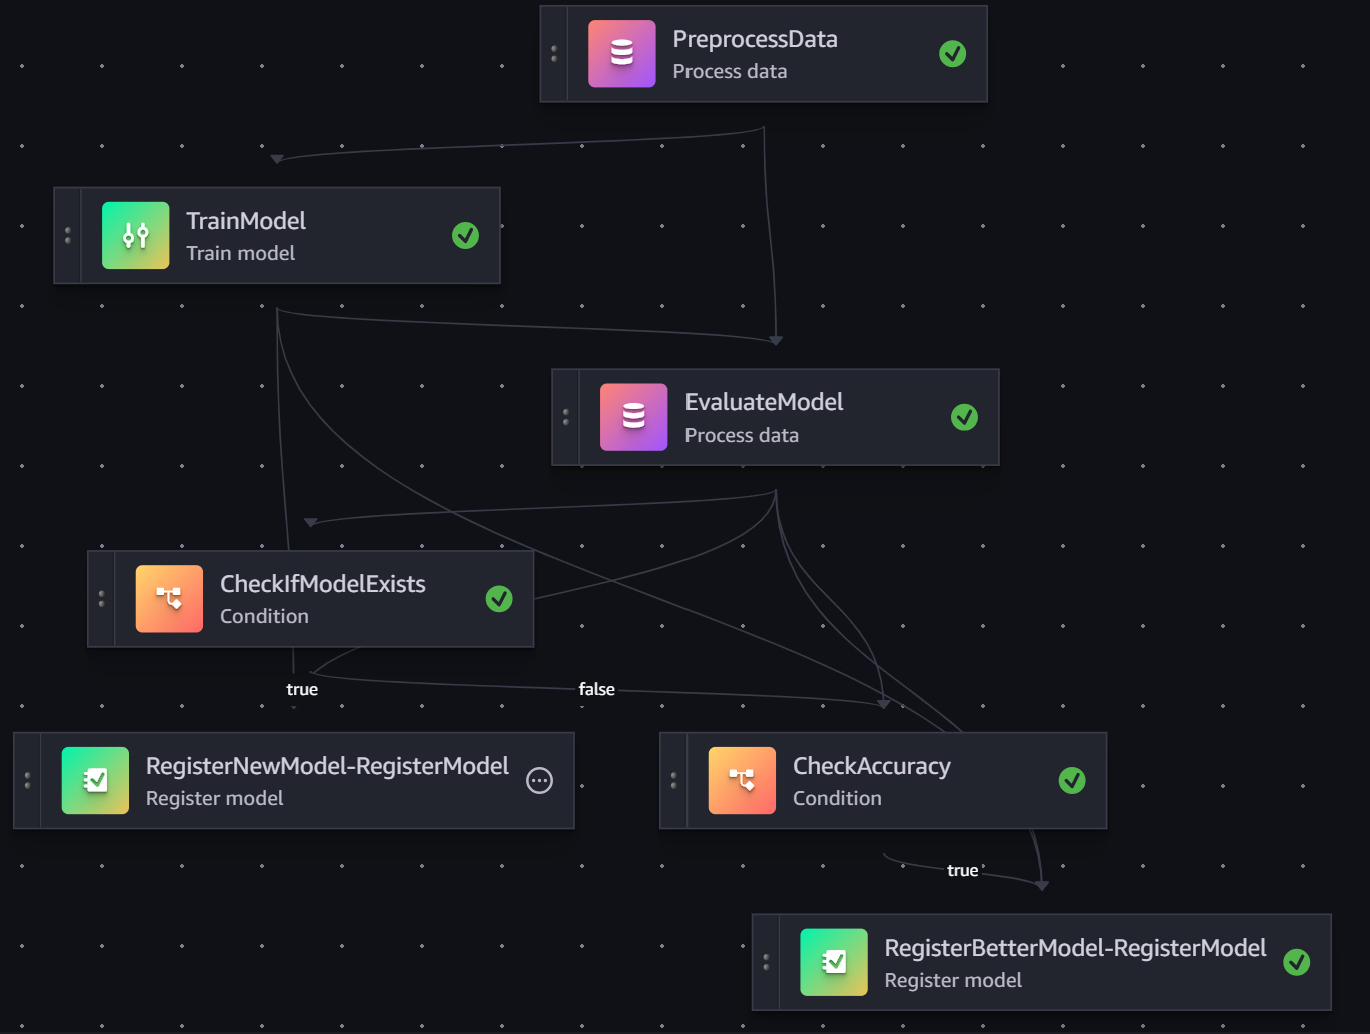

### Experiment Tracking

#### Experiment 1 vs Experiment  2
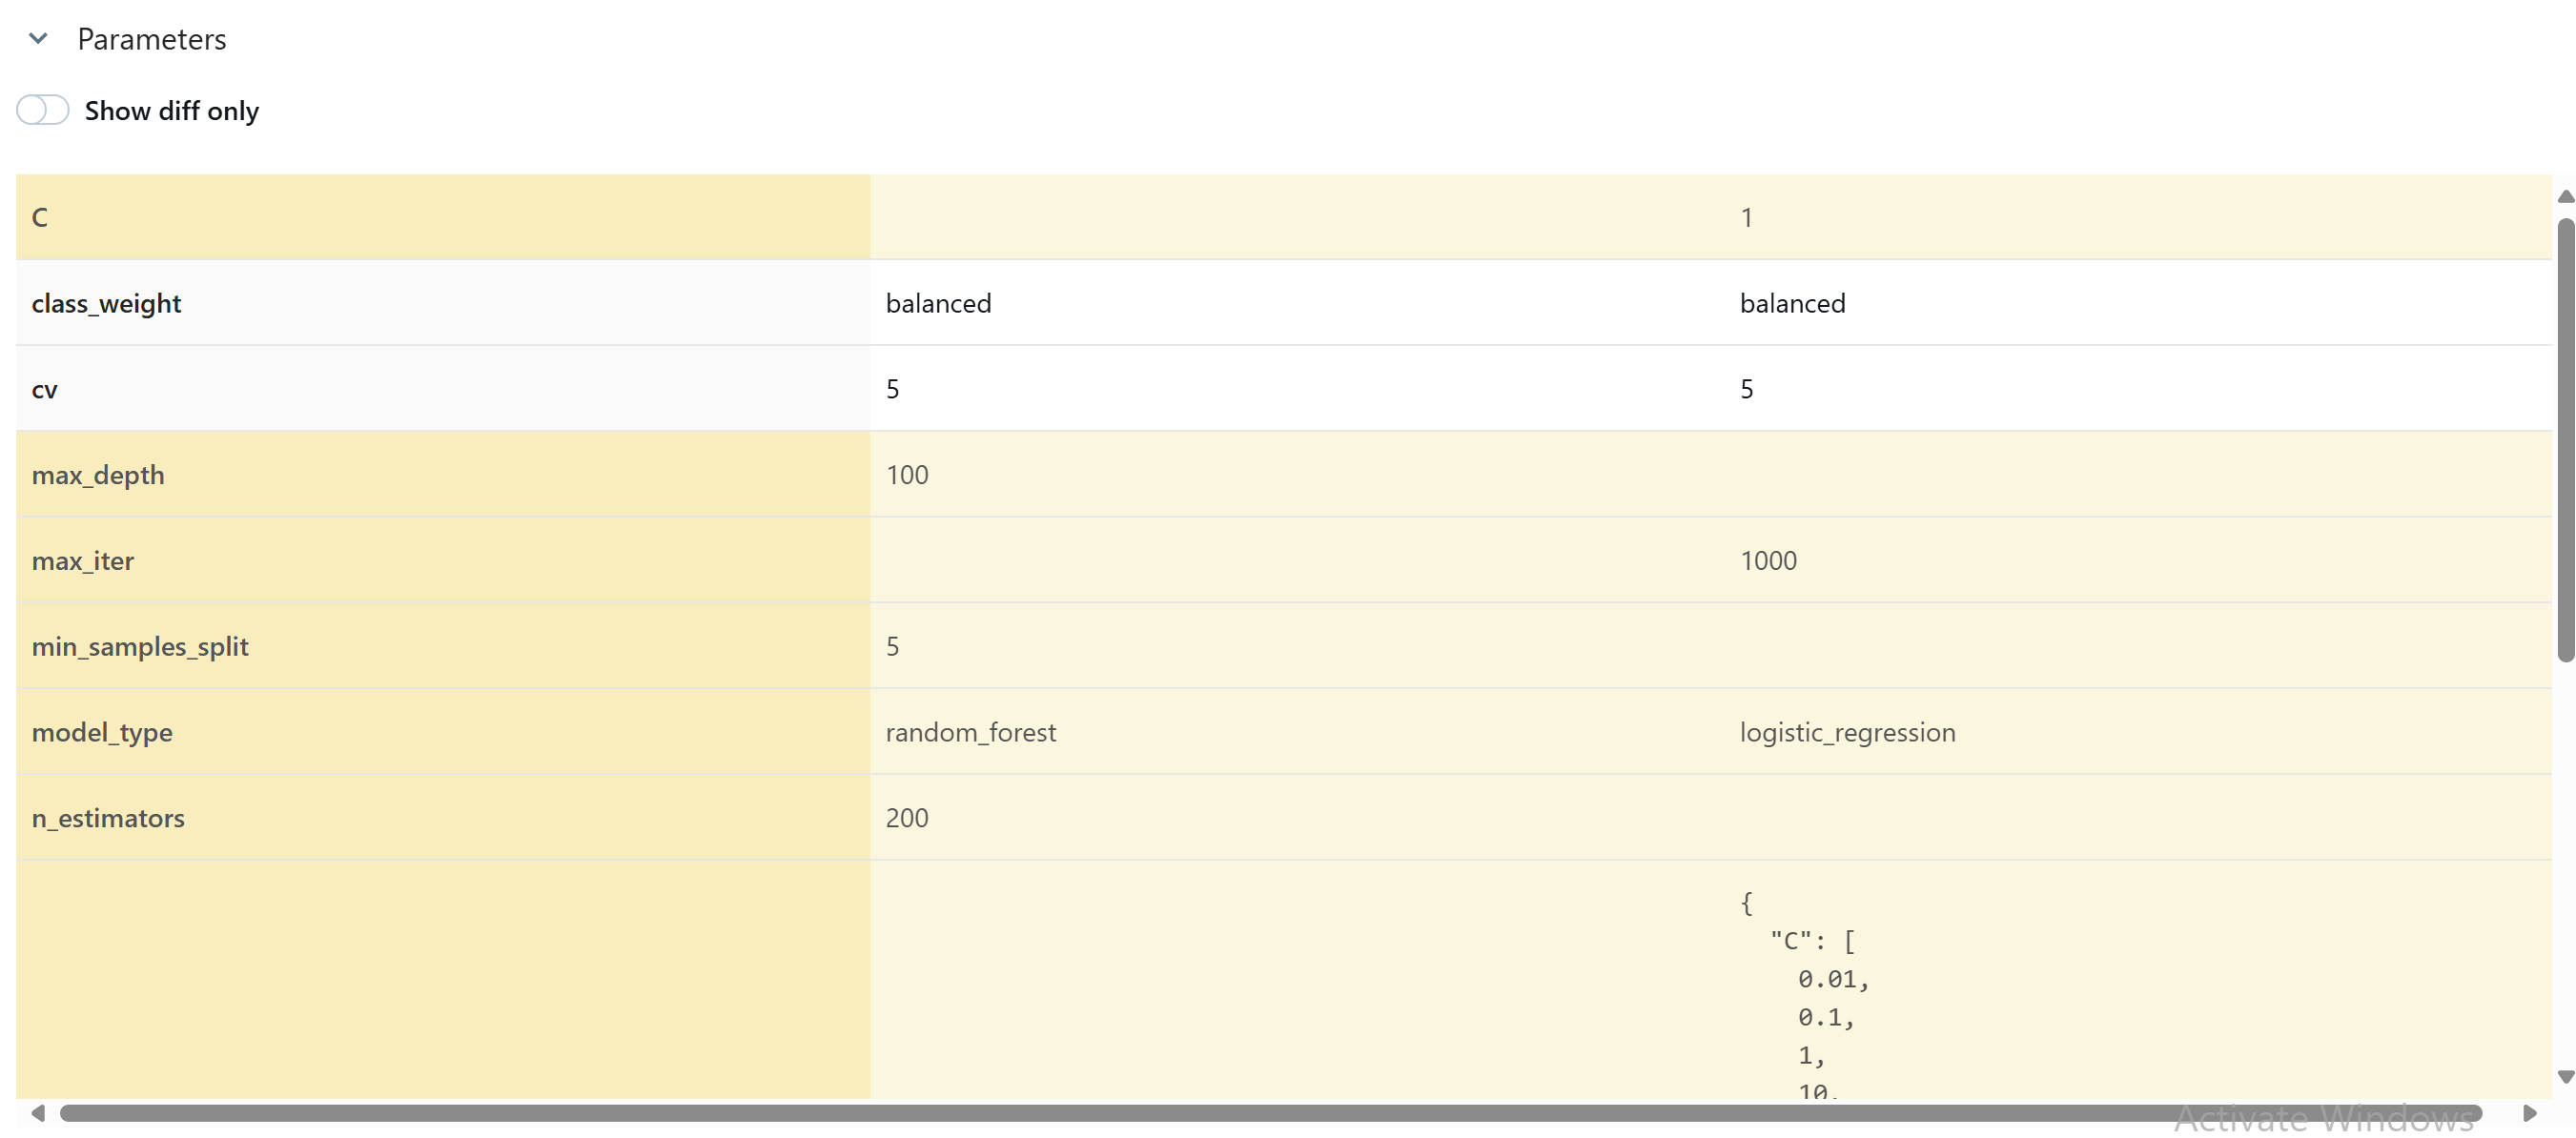
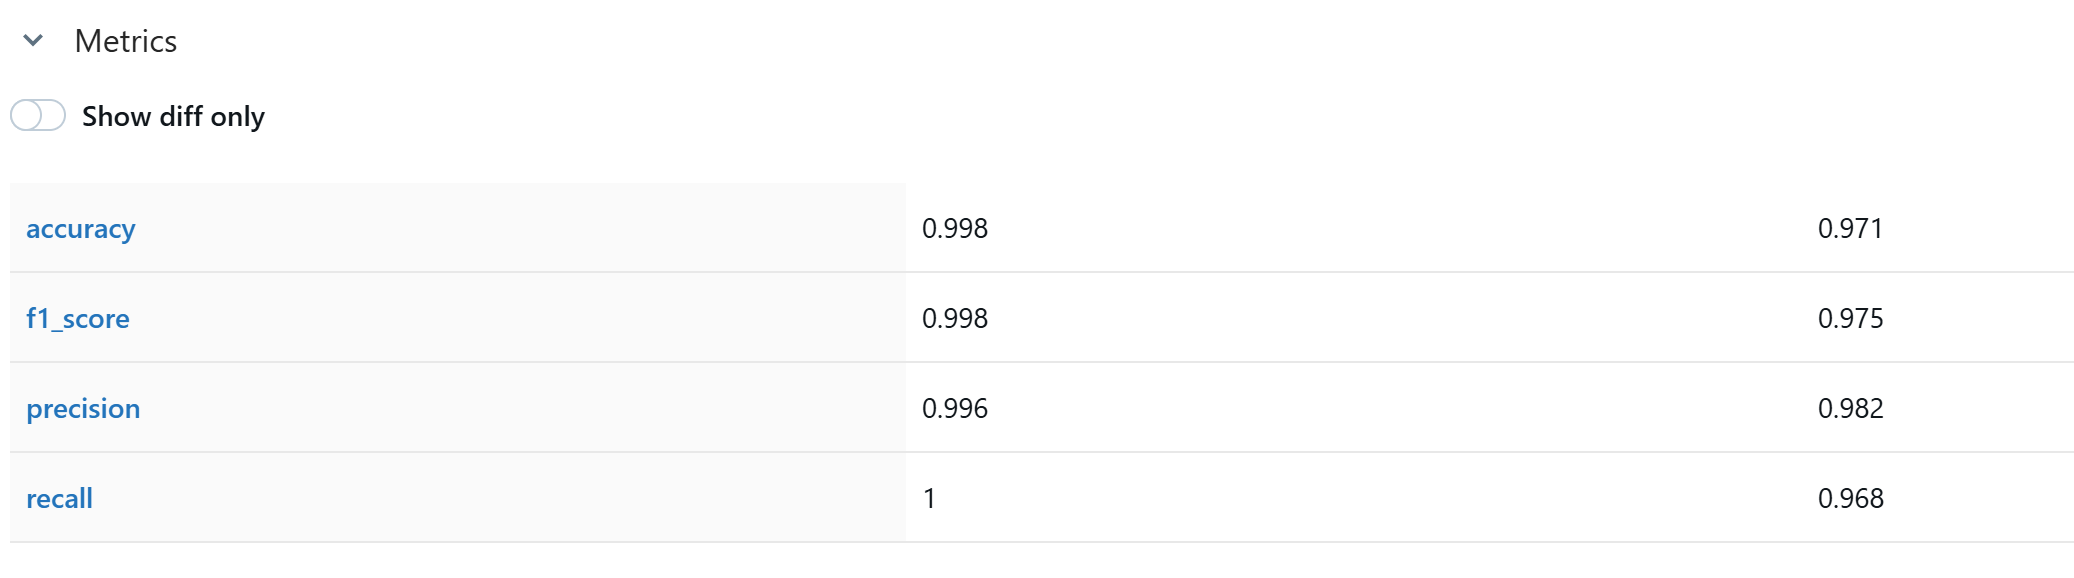
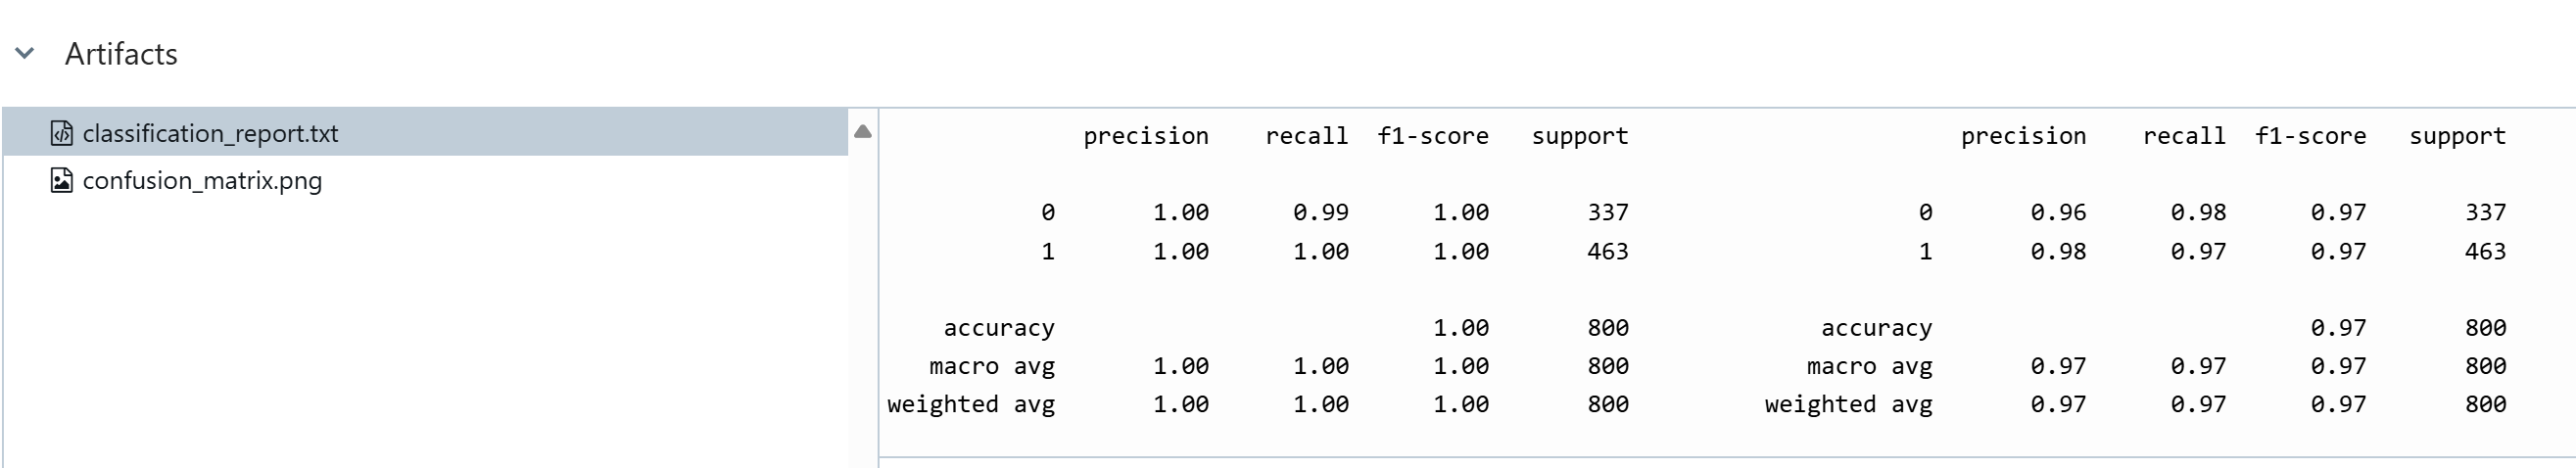
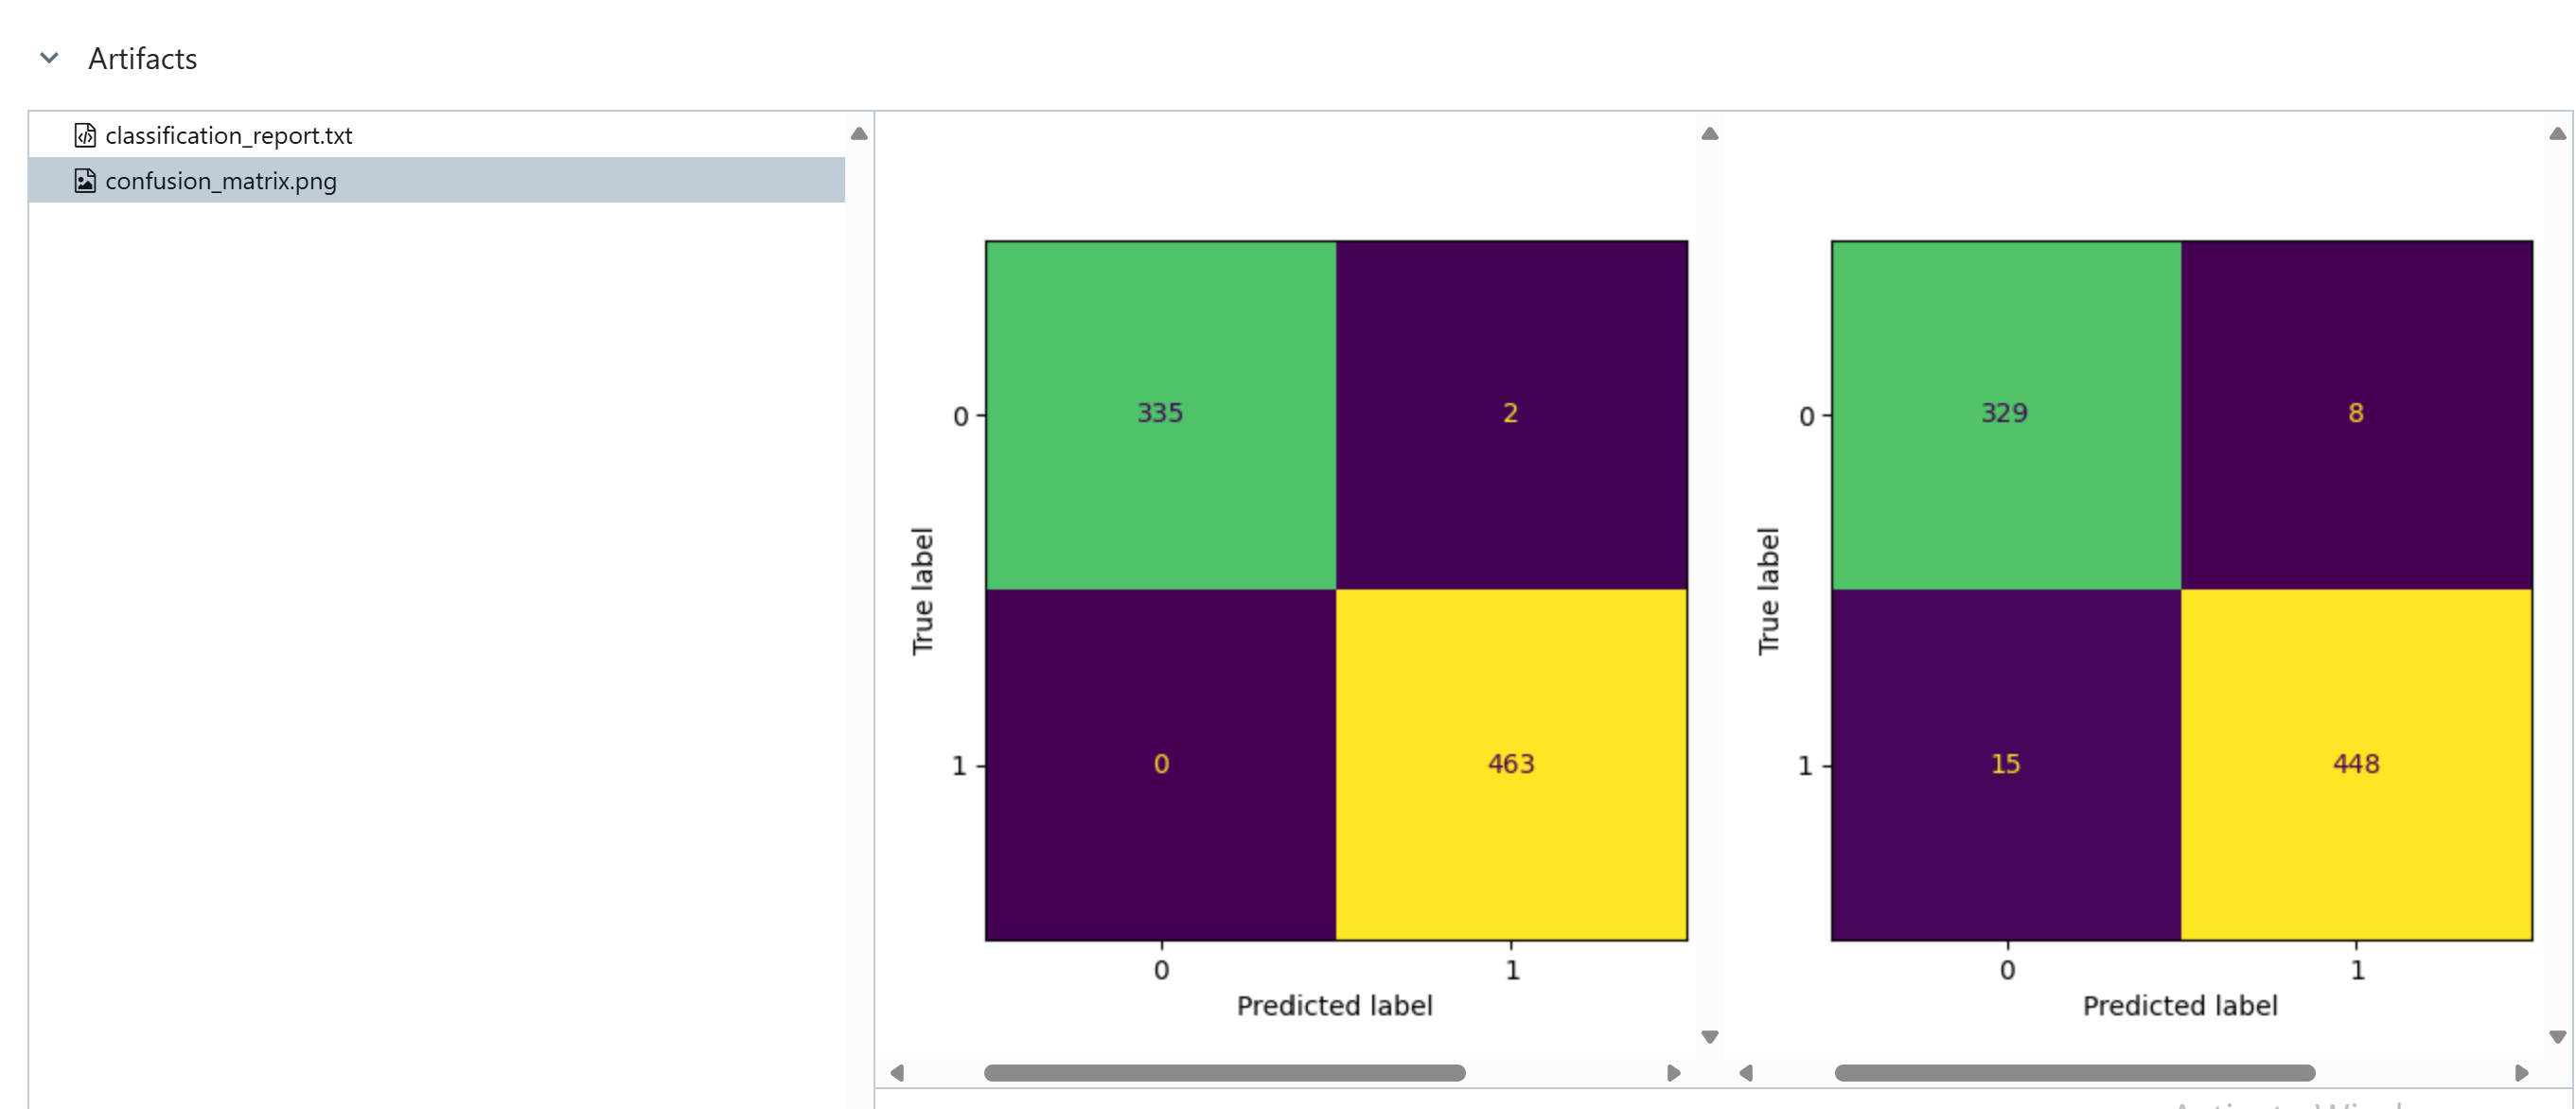

----
### Create Deployment Pipeline

Create a separate pipeline that is triggered by a new model registration. This pipeline will deploy the model to a SageMaker endpoint.

----
#### Deployment Pipeline Definition

This pipeline will be triggered when a new model is registered.

In [42]:
from sagemaker.workflow.steps import ProcessingStep
from sagemaker.processing import ScriptProcessor
from sagemaker.workflow.pipeline import Pipeline
from sagemaker.workflow.parameters import ParameterString
import sagemaker


# Define Parameters for the deployment pipeline
# This will be provided by the EventBridge trigger
model_package_arn_param = ParameterString(name="ModelPackageArn", default_value="")
role_param = ParameterString(name="ExecutionRole", default_value=role)
endpoint_name_param = ParameterString(name="EndpointName", default_value="Team2-predictor-endpoint")

# Create a ScriptProcessor for deployment
# Using a more recent scikit-learn version is generally a good idea
deploy_processor = ScriptProcessor(
    image_uri=sagemaker.image_uris.retrieve("sklearn", sagemaker_session.boto_region_name, version="1.2-1"),
    command=["python3"],
    instance_type="ml.t3.medium",
    instance_count=1,
    role=role_param,
    base_job_name="deploy-registered-model"
)

# Define the deployment step that takes the model ARN as an argument
step_deploy = ProcessingStep(
    name="DeployRegisteredModel",
    processor=deploy_processor,
    inputs=[ProcessingInput(source="source/", destination="/opt/ml/processing/input/scripts")],
    code="source/deploy.py",
    job_arguments=[
        "--model-package-arn", model_package_arn_param,
        "--role", role_param,
        "--endpoint-name", endpoint_name_param,
        "--region", "ap-southeast-1" 
    ]
)

# Define the independent deployment pipeline
deploy_pipeline = Pipeline(
    name="Team2DeployPipeline",
    parameters=[model_package_arn_param, role_param, endpoint_name_param],
    steps=[step_deploy],
)

# Create or update the pipeline definition
# Capture the response which contains the ARN
response = deploy_pipeline.upsert(role_arn=role)

# Extract the ARN from the response dictionary
pipeline_arn = response['PipelineArn']

print(f"Deployment pipeline ARN: {pipeline_arn}")
print('Deployment pipeline created.')

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.


Deployment pipeline ARN: arn:aws:sagemaker:ap-southeast-1:837028399719:pipeline/Team2DeployPipeline
Deployment pipeline created.


#### Approve registered model

In [8]:
import boto3

model_group_name = "Team2PredictorModels"
region = "ap-southeast-1"

sagemaker_client = boto3.client("sagemaker", region_name=region)

response = sagemaker_client.list_model_packages(ModelPackageGroupName=model_group_name)

#approve PendingManualApproval model
for model in response["ModelPackageSummaryList"]:
    if model["ModelApprovalStatus"] == "PendingManualApproval":
        print("Approving:", model["ModelPackageArn"])
        sagemaker_client.update_model_package(
            ModelPackageArn=model["ModelPackageArn"],
            ModelApprovalStatus="Approved",
            ApprovalDescription="Auto-approved after validation."
        )

Approving: arn:aws:sagemaker:ap-southeast-1:837028399719:model-package/Team2PredictorModels/29
Approving: arn:aws:sagemaker:ap-southeast-1:837028399719:model-package/Team2PredictorModels/28
Approving: arn:aws:sagemaker:ap-southeast-1:837028399719:model-package/Team2PredictorModels/27


#### Manual Trigger deployment pipeline

In [43]:
#manual trigger
import boto3
from sagemaker.workflow.pipeline import Pipeline

# === CONFIGURATION ===
region = "ap-southeast-1"
model_group_name = "Team2PredictorModels"
pipeline_name = "Team2DeployPipeline"  # Your SageMaker pipeline name
parameter_name = "ModelPackageArn"     # Your pipeline's parameter name

# Initialize SageMaker client
# sagemaker_client = boto3.client("sagemaker", region_name=region)
boto_session = boto3.Session(region_name=region)
sagemaker_client = boto_session.client("sagemaker")
sagemaker_session = sagemaker.Session(boto_session=boto_session)

#Find the latest approved model package
approved_models = sagemaker_client.list_model_packages(
    ModelPackageGroupName=model_group_name,
    ModelApprovalStatus="Approved",
    SortBy="CreationTime",
    SortOrder="Descending",
    MaxResults=1
)

if not approved_models["ModelPackageSummaryList"]:
    print("❌ No approved models found.")
    exit(1)

model_package_arn = approved_models["ModelPackageSummaryList"][0]["ModelPackageArn"]
print(f"Latest approved model ARN: {model_package_arn}")

# Load existing pipeline
pipeline = Pipeline(name=pipeline_name, sagemaker_session=sagemaker_session)

execution = pipeline.start(
    parameters={
        "ModelPackageArn": model_package_arn
    }
)

print("Deployment pipeline execution.")
print(execution.arn)
execution.wait()
execution.describe()

Latest approved model ARN: arn:aws:sagemaker:ap-southeast-1:837028399719:model-package/Team2PredictorModels/29
Deployment pipeline execution.
arn:aws:sagemaker:ap-southeast-1:837028399719:pipeline/Team2DeployPipeline/execution/6z54f91flh06


{'PipelineArn': 'arn:aws:sagemaker:ap-southeast-1:837028399719:pipeline/Team2DeployPipeline',
 'PipelineExecutionArn': 'arn:aws:sagemaker:ap-southeast-1:837028399719:pipeline/Team2DeployPipeline/execution/6z54f91flh06',
 'PipelineExecutionDisplayName': 'execution-1756134657896',
 'PipelineExecutionStatus': 'Succeeded',
 'PipelineExperimentConfig': {'ExperimentName': 'team2deploypipeline',
  'TrialName': '6z54f91flh06'},
 'CreationTime': datetime.datetime(2025, 8, 25, 15, 10, 57, 756000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2025, 8, 25, 15, 18, 32, 283000, tzinfo=tzlocal()),
 'CreatedBy': {'IamIdentity': {'Arn': 'arn:aws:sts::837028399719:assumed-role/iti113-team2-sagemaker-iti113-team2-domain-iti113-team2-Role/SageMaker',
   'PrincipalId': 'AROA4FYWHZJTTV2RRPWJ5:SageMaker'}},
 'LastModifiedBy': {'IamIdentity': {'Arn': 'arn:aws:sts::837028399719:assumed-role/iti113-team2-sagemaker-iti113-team2-domain-iti113-team2-Role/SageMaker',
   'PrincipalId': 'AROA4FYWHZJTTV2RR

-----
#### Create EventBridge To Trigger deployment pipeline

In [10]:
import sagemaker
import boto3
import json

# Initialize the EventBridge client
events_client = boto3.client("events", region_name="ap-southeast-1")

role = sagemaker.get_execution_role()
model_group_name = "Team2PredictorModels"
rule_name = "Team2-TriggerDeploymentOnApproval"

target_arn = "arn:aws:sagemaker:ap-southeast-1:837028399719:pipeline/Team2DeployPipeline"
log_group_arn = "arn:aws:logs:ap-southeast-1:837028399719:log-group:/aws/events/sagemaker-capture"

# Define the event pattern to listen for
# This pattern triggers when a model package in your group has its status changed to "Approved"
event_pattern = {
    "source": ["aws.sagemaker"],
    "detail-type": ["SageMaker Model Package State Change"]
    # "detail": {
    #     "ModelPackageGroupName": [model_group_name], 
    #     "ModelApprovalStatus": ["Approved"]
    # }
}

log_target = {
    "Id": "LogTarget",
    "Arn": log_group_arn
}

target = {
    "Id": "Team2DeployPipelineTarget",
    "Arn": target_arn,  # The ARN of the deploy pipeline 
    "RoleArn": role,      # The execution role for the pipeline
    "SageMakerPipelineParameters": {
        "PipelineParameterList": [
            {
                "Name": "ModelPackageArn",
                "Value": "$.detail.ModelPackageArn"
            }
        ]
    }
}

# Create or update the EventBridge rule
try:
    print(f"Creating or updating EventBridge rule: {rule_name}")
    response = events_client.put_rule(
        Name=rule_name,
        EventPattern=json.dumps(event_pattern),
        State="ENABLED",
        Description="Triggers to deploy model when approved."
    )

    events_client.put_targets(Rule=rule_name, Targets=[target, log_target])
   
    print("EventBridge rule created successfully!")
    
except Exception as e:
    print(f"Error creating rule: {e}")

Creating or updating EventBridge rule: Team2-TriggerDeploymentOnApproval
EventBridge rule created successfully!


#### EventBridge rule
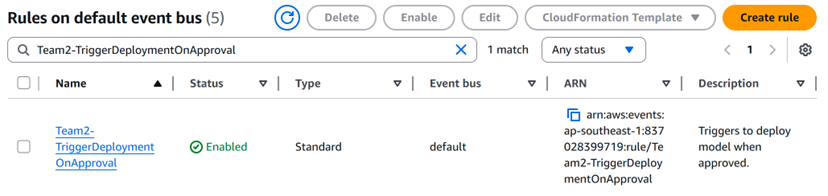

### DeployPipeline Graph and Endpoint
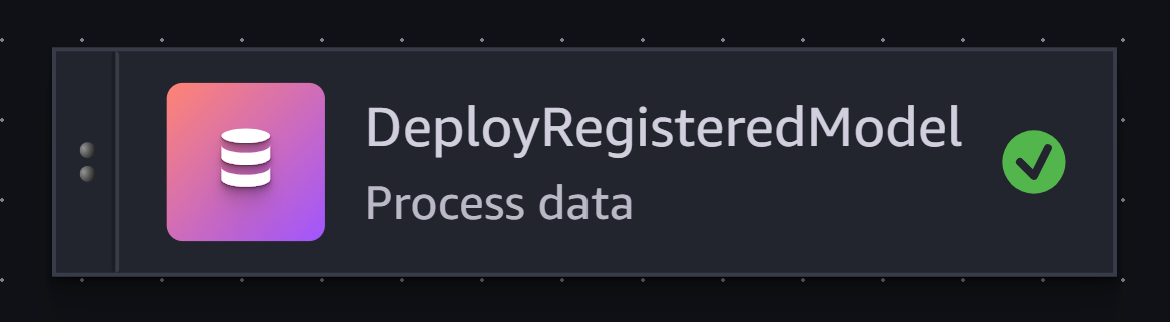
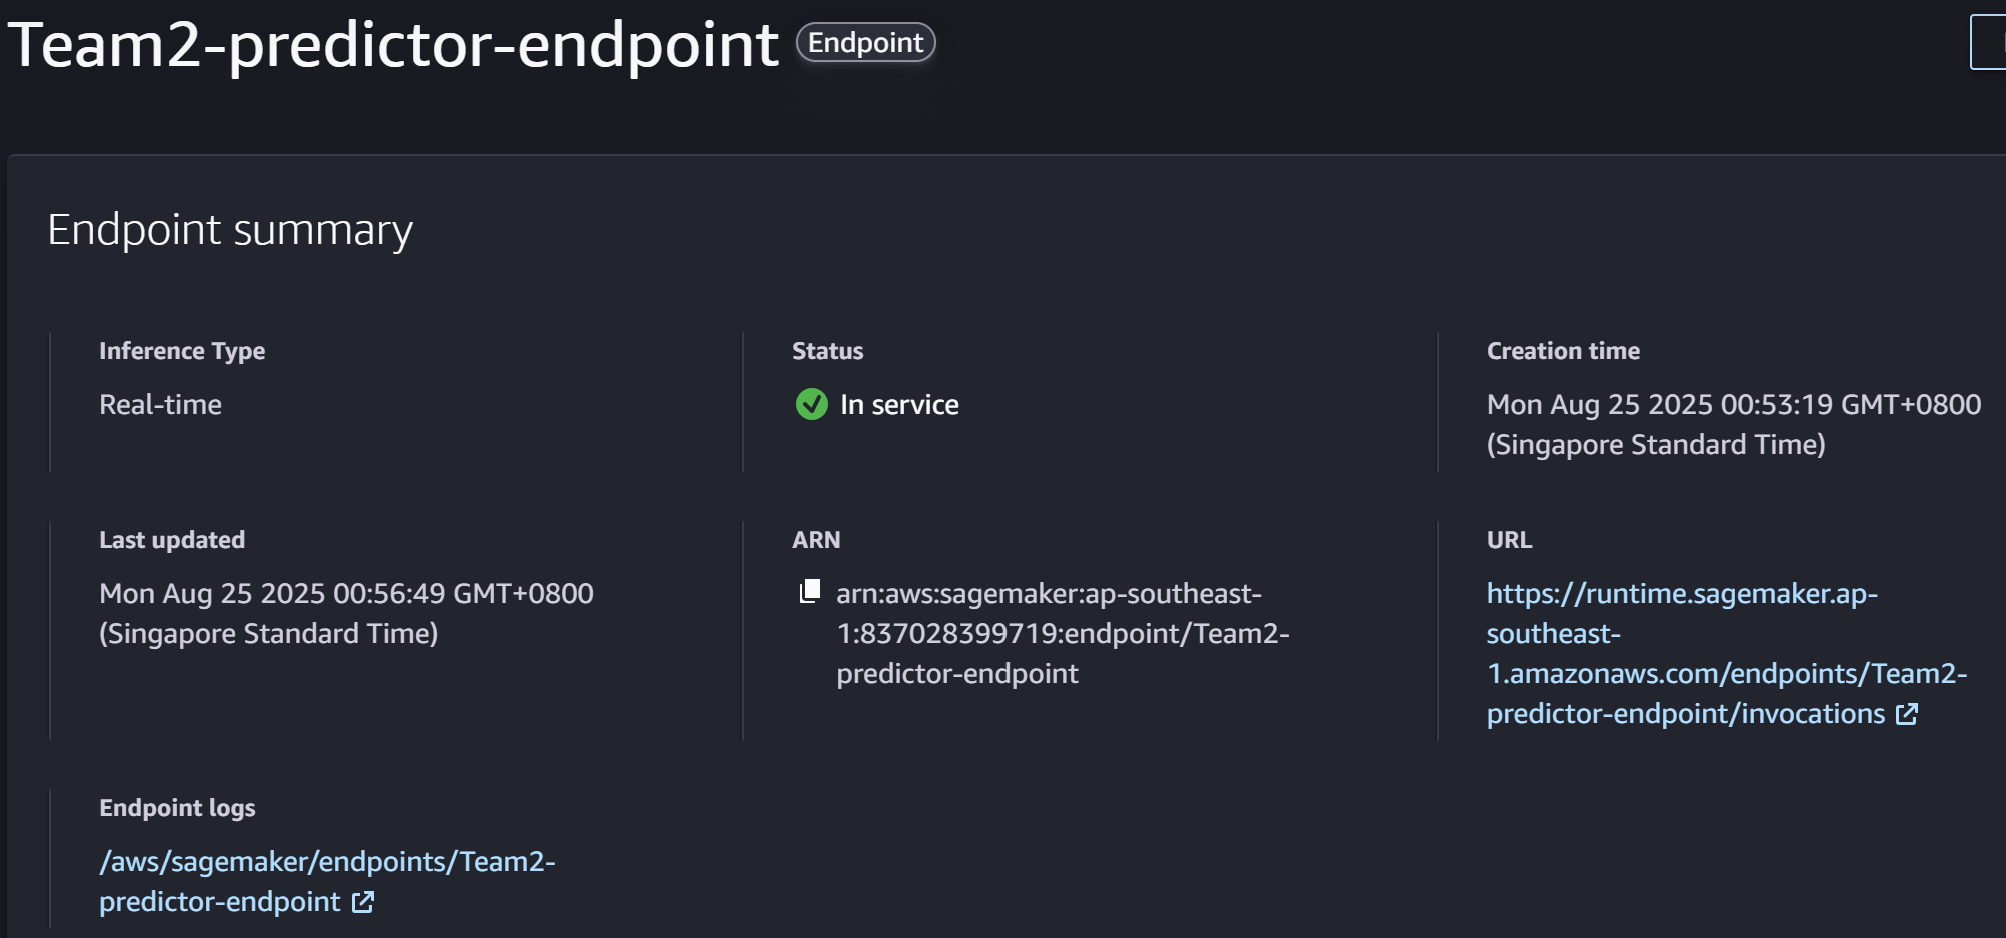

### Invoking the Endpoint

In [36]:
import boto3
import json
import numpy as np
import pandas as pd
import sagemaker

# Define endpoint name using the same name deployed
endpoint_name = "Team2-predictor-endpoint"

aws_region = "ap-southeast-1"

# Create a client to interact with the SageMaker endpoint
sagemaker_client = boto3.client("sagemaker", region_name=aws_region)
sagemaker_runtime_client = boto3.client("sagemaker-runtime", region_name=aws_region)

# 2. Prepare your test data (payload)
s3 = boto3.client("s3")
sagemaker_session = sagemaker.Session()
bucket_name = 'iti113-team2-bucket'
base_folder = 'Team2'

#test with test.csv
s3_process_test_path = f"s3://{bucket_name}/{base_folder}/processing/test/v1/test.csv"
df = pd.read_csv(s3_process_test_path)
df = df.drop("target", axis=1)

#send test records
sample_data_point = df.head(5).to_dict(orient="records")
payload = {"data": sample_data_point}
print(f"Sending payload: {json.dumps(payload)}")

# 3. Invoke the endpoint and get the prediction
try:
    response = sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
    endpoint_arn = response["EndpointArn"]
    print("\nEndpoint ARN:", endpoint_arn)

    response = sagemaker_runtime_client.invoke_endpoint(
        EndpointName=endpoint_name,
        ContentType="application/json",
        Body=json.dumps(payload) # Serialize the payload to a JSON string
    )

    # The response body is a streaming object, so we need to read and decode it
    response_body = response['Body'].read()
    result = json.loads(response_body.decode('utf-8'))

    print(f"\nContentType: {response["ContentType"]}")
    print("\nSuccess!")
    print(f"Prediction result: {result}")

except Exception as e:
    print(f"Error invoking endpoint: {e}")

Sending payload: {"data": [{"restingBP": -0.1584962155850272, "serumcholestrol": 1.3261537378056152, "maxheartrate": 0.980974287811504, "oldpeak": 0.2280956321093852, "gender_0": 0.0, "gender_1": 1.0, "chestpain_0": 1.0, "chestpain_1": 0.0, "chestpain_2": 0.0, "chestpain_3": 0.0, "fastingbloodsugar_0": 1.0, "fastingbloodsugar_1": 0.0, "restingrelectro_0": 0.0, "restingrelectro_1": 1.0, "restingrelectro_2": 0.0, "exerciseangia_0": 1.0, "exerciseangia_1": 0.0, "slope_0": 0.0, "slope_1": 0.0, "slope_2": 1.0, "slope_3": 0.0, "noofmajorvessels_0": 0.0, "noofmajorvessels_1": 1.0, "noofmajorvessels_2": 0.0, "noofmajorvessels_3": 0.0}, {"restingBP": 0.0084473441211311, "serumcholestrol": -1.310244697391503, "maxheartrate": 1.566228762537217, "oldpeak": -1.5743424498154024, "gender_0": 0.0, "gender_1": 1.0, "chestpain_0": 1.0, "chestpain_1": 0.0, "chestpain_2": 0.0, "chestpain_3": 0.0, "fastingbloodsugar_0": 1.0, "fastingbloodsugar_1": 0.0, "restingrelectro_0": 1.0, "restingrelectro_1": 0.0, "r

### Clean Endpoint

In [39]:
#clean up endpoint
endpoint_name = "Team2-predictor-endpoint"
endpoint_config_name = "Team2-predictor-endpoint"
try:
    sagemaker_client.delete_endpoint(EndpointName=endpoint_name)
    print(f"🛑 Deleting {endpoint_name}")
    sagemaker_client.describe_endpoint_config(EndpointConfigName=endpoint_config_name)
    print(f"🛑 EndpointConfig '{endpoint_config_name}' already exists. Deleting it...")
    sagemaker_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
    print("Endpoint deleted.")
except sagemaker_client.exceptions.ClientError as e:
        # If the resources don't exist, that's fine.
    if "Could not find" not in str(e):
        raise e

### View Cloudwatch Logs

You can view the cloudwatch logs. Here is an example for the logs of a previous endpoint.

In [10]:
import boto3

# Enter the name of your SageMaker endpoint
endpoint_name = "Team2-predictor-endpoint"

# The log group is created based on the endpoint name
log_group_name = f"/aws/sagemaker/Endpoints/{endpoint_name}"

# Create a CloudWatch Logs client
logs_client = boto3.client("logs")

print(f"Searching for logs in: {log_group_name}\n")

try:
    # Find all log streams in the log group, ordered by the most recent
    response = logs_client.describe_log_streams(
        logGroupName=log_group_name,
        orderBy='LastEventTime',
        descending=True
    )

    log_streams = response.get("logStreams", [])

    if not log_streams:
        print("No log streams found. The endpoint might not have processed any requests yet.")
    
    # Loop through each stream and print its recent log events
    for stream in log_streams:
        stream_name = stream['logStreamName']
        print(f"--- Logs from stream: {stream_name} ---")

        # Get log events from the stream
        log_events = logs_client.get_log_events(
            logGroupName=log_group_name,
            logStreamName=stream_name,
            startFromHead=False,  # False gets recent logs first
            limit=50  # Get up to 50 recent log events
        )
        
        # Print events in chronological order
        for event in reversed(log_events.get("events", [])):
            print(event['message'].strip())
        
        print("-" * (len(stream_name) + 24), "\n")

except logs_client.exceptions.ResourceNotFoundException:
    print(f"Error: Log group '{log_group_name}' was not found.")
    print("Please check the endpoint name and ensure it has been invoked.")
except Exception as e:
    print(f"An error occurred: {e}")

Searching for logs in: /aws/sagemaker/Endpoints/Team2-predictor-endpoint

--- Logs from stream: AllTraffic/i-077a6c7d99a2e8cda ---
169.254.178.2 - - [24/Aug/2025:15:54:41 +0000] "GET /ping HTTP/1.1" 200 0 "-" "AHC/2.0"
169.254.178.2 - - [24/Aug/2025:15:54:36 +0000] "GET /ping HTTP/1.1" 200 0 "-" "AHC/2.0"
169.254.178.2 - - [24/Aug/2025:15:54:31 +0000] "GET /ping HTTP/1.1" 200 0 "-" "AHC/2.0"
169.254.178.2 - - [24/Aug/2025:15:54:26 +0000] "GET /ping HTTP/1.1" 200 0 "-" "AHC/2.0"
169.254.178.2 - - [24/Aug/2025:15:54:21 +0000] "GET /ping HTTP/1.1" 200 0 "-" "AHC/2.0"
169.254.178.2 - - [24/Aug/2025:15:54:16 +0000] "GET /ping HTTP/1.1" 200 0 "-" "AHC/2.0"
169.254.178.2 - - [24/Aug/2025:15:54:11 +0000] "GET /ping HTTP/1.1" 200 0 "-" "AHC/2.0"
169.254.178.2 - - [24/Aug/2025:15:54:06 +0000] "GET /ping HTTP/1.1" 200 0 "-" "AHC/2.0"
sagemaker_containers._errors.ClientError: Error parsing JSON: string indices must be integers
169.254.178.2 - - [24/Aug/2025:15:54:05 +0000] "POST /invocations HTTP/

#### Track all events log (Commented)

In [32]:
# import boto3
# from botocore.exceptions import ClientError

# logs_client = boto3.client('logs', region_name='ap-southeast-1')

# log_group_name = '/aws/sagemaker/ModelPackageGroup/Team2PredictorModels'  # example name, customize as you want

# try:
#     logs_client.create_log_group(logGroupName=log_group_name)
#     print(f"Log group '{log_group_name}' created successfully.")
# except ClientError as e:
#     if e.response['Error']['Code'] == 'ResourceAlreadyExistsException':
#         print(f"Log group '{log_group_name}' already exists.")
#     else:
#         print(f"Unexpected error: {e}")


Log group '/aws/sagemaker/ModelPackageGroup/Team2PredictorModels' created successfully.


In [38]:
# import boto3
# import json

# events_client = boto3.client("events", region_name="ap-southeast-1")

# rule_name = "TrackAllModelPackageGroupEvents"
# log_group_name = "/aws/sagemaker/ModelPackageGroup/Team2PredictorModels"
# role_arn = "arn:aws:iam::837028399719:role/EventBridgeSageMakerTriggerRole"

# # Remove leading slash for log group ARN construction
# log_group_name_no_slash = log_group_name.lstrip('/')

# # Event pattern to catch all events related to the ModelPackageGroupName
# event_pattern = {
#     "source": ["aws.sagemaker"],
#     "detail-type": ["SageMaker Model Package State Change"],
#     "detail": {
#         "ModelPackageGroupName": ["Team2PredictorModels"]
#     }
# }

# try:
#     # Create or update the EventBridge rule
#     response = events_client.put_rule(
#         Name=rule_name,
#         EventPattern=json.dumps(event_pattern),
#         State="ENABLED",
#         Description="Log all Model Package events for Team2PredictorModels"
#     )
#     rule_arn = response['RuleArn']
#     print(f"Rule ARN: {rule_arn}")

#     # Define the target to send events to CloudWatch Logs
#     target = {
#         "Id": "SendAllEventsToCloudWatchLogs",
#         "Arn": f"arn:aws:logs:ap-southeast-1:837028399719:log-group:{log_group_name_no_slash}",
#         "InputTransformer": {
#             "InputPathsMap": {
#                 "detail": "$.detail",
#                 "time": "$.time",
#                 "source": "$.source",
#                 "detailType": "$.detail-type"
#             },
#             "InputTemplate": json.dumps({
#                 "time": "<time>",
#                 "source": "<source>",
#                 "detail-type": "<detailType>",
#                 "detail": "<detail>"
#             })
#         }
#     }

#     # Add target to the rule
#     response = events_client.put_targets(
#         Rule=rule_name,
#         Targets=[target]
#     )

#     print("EventBridge target set to CloudWatch Logs successfully!")

# except Exception as e:
#     print(f"Error creating rule or target: {e}")


Rule ARN: arn:aws:events:ap-southeast-1:837028399719:rule/TrackAllModelPackageGroupEvents
EventBridge target set to CloudWatch Logs successfully!
